In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import itertools
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation,BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D

from keras.utils.generic_utils import get_custom_objects
from keras.optimizers import RMSprop, adam

from keras.utils import np_utils, plot_model
from keras.callbacks import ReduceLROnPlateau, CSVLogger,TensorBoard, ModelCheckpoint

from keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [2]:
(X_train, y_train),(X_test,y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0],28,28,1).astype('float32')
X_test = X_test.reshape(X_test.shape[0],28,28,1).astype('float32')

y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

num_classes = y_test.shape[1]

In [3]:
#Normalization
X_train = X_train/255.0
X_test = X_test/255.0

In [4]:
seed = 7

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,
                                                  test_size=0.2,                    
                                                  random_state=seed)
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)

(48000, 28, 28, 1)
(12000, 28, 28, 1)
(48000, 10)
(10000, 10)


In [6]:
class Swish(Activation):
    
    def __init__(self, activation, **kwargs):
        super(Swish, self).__init__(activation, **kwargs)
        self.__name__ = 'Swish_s'

def swish(x):
    return K.sigmoid(x)*x

In [7]:
def cnn_model():
    model = Sequential()
    get_custom_objects().update({'Swish_s': Swish(swish)})
    model.add(Conv2D(32,(7,7), input_shape=(28,28,1), kernel_initializer='he_uniform',activation='Swish_s'))
    model.add(BatchNormalization())
    
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    
    model.add(Conv2D(32,(5,5), kernel_initializer='he_uniform',activation='Swish_s'))
    model.add(BatchNormalization())
    
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    
    model.add(Conv2D(32,(3,3), kernel_initializer='he_uniform',activation='Swish_s'))
    model.add(BatchNormalization())
    
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    
    model.add(Flatten())
    
    model.add(Dense(128, activation='selu',kernel_initializer='he_normal'))
    model.add(Dense(10,activation='selu',kernel_initializer='he_normal'))
    model.add(Dense(num_classes,activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
    return model

In [8]:
cnn_model = cnn_model()
print(cnn_model.summary())
plot_model(cnn_model, to_file='swish_activation_cnn.png')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 22, 22, 32)        1600      
_________________________________________________________________
batch_normalization_1 (Batch (None, 22, 22, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 32)          25632     
_________________________________________________________________
batch_normalization_2 (Batch (None, 7, 7, 32)          128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 2, 32)          9248      
__________

In [9]:
if not (os.path.isdir("logs_data")):
    os.makedirs('logs_data')


tb = TensorBoard(log_dir='logs', 
                 histogram_freq=0.3, 
                 batch_size=32, 
                 write_graph=True, 
                 write_grads=True, 
                 write_images=True, 
                 embeddings_freq=0, 
                 embeddings_layer_names=None, 
                 embeddings_metadata=None)

csv_logger = CSVLogger('log_data_aug.csv', append=True, separator=',')

checkpointer = ModelCheckpoint(filepath='swish_activation_conv2d_weights_data_augmnt.hdf5',verbose=1, save_best_only=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                           patience=3,
                                           verbose=1,
                                           factor=0.2,
                                           min_lr=0.001)

In [15]:
batch_size = 32
epochs = 200

In [12]:
train_data_gen = ImageDataGenerator(featurewise_center = True,
                                    samplewise_center = False,
                                    featurewise_std_normalization = True,
                                    samplewise_std_normalization = False,
                                    zca_whitening = True,
                                    rotation_range = 10,
                                    zoom_range = 0.2,
                                    width_shift_range = 0.15,
                                    height_shift_range = 0.15,
                                    horizontal_flip = False,
                                    vertical_flip = False)

val_data_gen = ImageDataGenerator(featurewise_center = True,
                                    featurewise_std_normalization = True)

In [13]:
train_data_gen.fit(X_train)
val_data_gen.fit(X_val)

/home/stan/anaconda2/envs/tensorflow/lib/python3.5/site-packages/keras/preprocessing/image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (48000, 28, 28, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')
/home/stan/anaconda2/envs/tensorflow/lib/python3.5/site-packages/keras/preprocessing/image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (12000, 28, 28, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


In [17]:
train_generator = train_data_gen.flow(X_train,y_train, 
                               batch_size = batch_size)

val_generator  = val_data_gen.flow(X_val,y_val,
                              batch_size = batch_size)

In [22]:
history = cnn_model.fit_generator(train_generator,
                              epochs = epochs,
                              validation_data = val_generator,
                              verbose = 1,
                              steps_per_epoch = X_train.shape[0]//batch_size,
                              validation_steps = X_val.shape[0] // batch_size,
                              callbacks=[csv_logger,tb,checkpointer,learning_rate_reduction])

Epoch 1/200
1500/1500 [==============================] - 88s - loss: 1.0015 - acc: 0.6710 - val_loss: 0.4912 - val_acc: 0.8433
Epoch 2/200
1500/1500 [==============================] - 87s - loss: 0.3563 - acc: 0.8870 - val_loss: 0.2010 - val_acc: 0.9388
Epoch 3/200
1500/1500 [==============================] - 85s - loss: 0.2591 - acc: 0.9167 - val_loss: 0.1332 - val_acc: 0.9605
Epoch 4/200
1500/1500 [==============================] - 87s - loss: 0.2116 - acc: 0.9323 - val_loss: 0.1547 - val_acc: 0.9535
Epoch 5/200
1500/1500 [==============================] - 87s - loss: 0.1872 - acc: 0.9411 - val_loss: 0.1266 - val_acc: 0.9605
Epoch 6/200
1500/1500 [==============================] - 87s - loss: 0.1627 - acc: 0.9485 - val_loss: 0.1374 - val_acc: 0.9596
Epoch 7/200
1500/1500 [==============================] - 86s - loss: 0.1511 - acc: 0.9516 - val_loss: 0.0983 - val_acc: 0.9715
Epoch 8/200
1500/1500 [==============================] - 86s - loss: 0.1373 - acc: 0.9560 - val_loss: 0.0823 - 

1500/1500 [==============================] - 86s - loss: 0.0843 - acc: 0.9736 - val_loss: 0.0741 - val_acc: 0.9808
Epoch 32/200
1500/1500 [==============================] - 85s - loss: 0.0812 - acc: 0.9742 - val_loss: 0.0540 - val_acc: 0.9858
Epoch 33/200
1500/1500 [==============================] - 85s - loss: 0.0796 - acc: 0.9745 - val_loss: 0.0739 - val_acc: 0.9798
Epoch 34/200
1500/1500 [==============================] - 86s - loss: 0.0786 - acc: 0.9754 - val_loss: 0.0737 - val_acc: 0.9798
Epoch 35/200
1500/1500 [==============================] - 85s - loss: 0.0783 - acc: 0.9742 - val_loss: 0.0651 - val_acc: 0.9815
Epoch 36/200
1500/1500 [==============================] - 86s - loss: 0.0757 - acc: 0.9763 - val_loss: 0.0621 - val_acc: 0.9832
Epoch 37/200
1500/1500 [==============================] - 86s - loss: 0.0764 - acc: 0.9754 - val_loss: 0.0682 - val_acc: 0.9807
Epoch 38/200
1500/1500 [==============================] - 87s - loss: 0.0791 - acc: 0.9744 - val_loss: 0.0716 - val_a

1500/1500 [==============================] - 88s - loss: 0.0650 - acc: 0.9799 - val_loss: 0.0469 - val_acc: 0.9879
Epoch 64/200
1500/1500 [==============================] - 87s - loss: 0.0648 - acc: 0.9792 - val_loss: 0.0606 - val_acc: 0.9853
Epoch 65/200
1500/1500 [==============================] - 85s - loss: 0.0653 - acc: 0.9795 - val_loss: 0.0599 - val_acc: 0.9848
Epoch 66/200
1500/1500 [==============================] - 84s - loss: 0.0652 - acc: 0.9789 - val_loss: 0.0591 - val_acc: 0.9836
Epoch 67/200
1500/1500 [==============================] - 85s - loss: 0.0622 - acc: 0.9801 - val_loss: 0.0535 - val_acc: 0.9851
Epoch 68/200
1500/1500 [==============================] - 86s - loss: 0.0611 - acc: 0.9807 - val_loss: 0.0678 - val_acc: 0.9832
Epoch 69/200
1500/1500 [==============================] - 85s - loss: 0.0638 - acc: 0.9799 - val_loss: 0.0581 - val_acc: 0.9837
Epoch 70/200
1500/1500 [==============================] - 87s - loss: 0.0622 - acc: 0.9799 - val_loss: 0.0741 - val_a

1500/1500 [==============================] - 85s - loss: 0.0593 - acc: 0.9822 - val_loss: 0.0571 - val_acc: 0.9846
Epoch 96/200
1500/1500 [==============================] - 85s - loss: 0.0582 - acc: 0.9819 - val_loss: 0.0515 - val_acc: 0.9861
Epoch 97/200
1500/1500 [==============================] - 85s - loss: 0.0543 - acc: 0.9824 - val_loss: 0.0470 - val_acc: 0.9878
Epoch 98/200
1500/1500 [==============================] - 85s - loss: 0.0581 - acc: 0.9821 - val_loss: 0.0519 - val_acc: 0.9860
Epoch 99/200
1500/1500 [==============================] - 85s - loss: 0.0560 - acc: 0.9821 - val_loss: 0.0495 - val_acc: 0.9866
Epoch 100/200
1500/1500 [==============================] - 85s - loss: 0.0544 - acc: 0.9832 - val_loss: 0.0595 - val_acc: 0.9852
Epoch 101/200
1500/1500 [==============================] - 85s - loss: 0.0555 - acc: 0.9826 - val_loss: 0.0598 - val_acc: 0.9838
Epoch 102/200
1500/1500 [==============================] - 85s - loss: 0.0541 - acc: 0.9828 - val_loss: 0.0545 - va

1500/1500 [==============================] - 84s - loss: 0.0544 - acc: 0.9834 - val_loss: 0.0540 - val_acc: 0.9858
Epoch 129/200
1500/1500 [==============================] - 83s - loss: 0.0523 - acc: 0.9832 - val_loss: 0.0459 - val_acc: 0.9885
Epoch 130/200
1500/1500 [==============================] - 84s - loss: 0.0510 - acc: 0.9839 - val_loss: 0.0551 - val_acc: 0.9860
Epoch 131/200
1500/1500 [==============================] - 85s - loss: 0.0532 - acc: 0.9836 - val_loss: 0.0445 - val_acc: 0.9882
Epoch 132/200
1500/1500 [==============================] - 88s - loss: 0.0536 - acc: 0.9833 - val_loss: 0.0555 - val_acc: 0.9861
Epoch 133/200
1500/1500 [==============================] - 85s - loss: 0.0524 - acc: 0.9833 - val_loss: 0.0487 - val_acc: 0.9871
Epoch 134/200
1500/1500 [==============================] - 86s - loss: 0.0537 - acc: 0.9829 - val_loss: 0.0532 - val_acc: 0.9858
Epoch 135/200
1500/1500 [==============================] - 87s - loss: 0.0528 - acc: 0.9836 - val_loss: 0.0547 

1500/1500 [==============================] - 85s - loss: 0.0491 - acc: 0.9840 - val_loss: 0.0544 - val_acc: 0.9866
Epoch 161/200
1500/1500 [==============================] - 84s - loss: 0.0504 - acc: 0.9842 - val_loss: 0.0594 - val_acc: 0.9855
Epoch 162/200
1500/1500 [==============================] - 84s - loss: 0.0498 - acc: 0.9841 - val_loss: 0.0499 - val_acc: 0.9881
Epoch 163/200
1500/1500 [==============================] - 85s - loss: 0.0498 - acc: 0.9836 - val_loss: 0.0480 - val_acc: 0.9880
Epoch 164/200
1500/1500 [==============================] - 84s - loss: 0.0489 - acc: 0.9848 - val_loss: 0.0470 - val_acc: 0.9878
Epoch 165/200
1500/1500 [==============================] - 84s - loss: 0.0477 - acc: 0.9843 - val_loss: 0.0529 - val_acc: 0.9883
Epoch 166/200
1500/1500 [==============================] - 85s - loss: 0.0465 - acc: 0.9852 - val_loss: 0.0572 - val_acc: 0.9861
Epoch 167/200
1500/1500 [==============================] - 85s - loss: 0.0493 - acc: 0.9842 - val_loss: 0.0583 

1500/1500 [==============================] - 85s - loss: 0.0466 - acc: 0.9851 - val_loss: 0.0492 - val_acc: 0.9877
Epoch 193/200
1500/1500 [==============================] - 84s - loss: 0.0488 - acc: 0.9842 - val_loss: 0.0516 - val_acc: 0.9873
Epoch 194/200
1500/1500 [==============================] - 84s - loss: 0.0478 - acc: 0.9850 - val_loss: 0.0484 - val_acc: 0.9875
Epoch 195/200
1500/1500 [==============================] - 84s - loss: 0.0472 - acc: 0.9850 - val_loss: 0.0505 - val_acc: 0.9874
Epoch 196/200
1500/1500 [==============================] - 85s - loss: 0.0485 - acc: 0.9853 - val_loss: 0.0524 - val_acc: 0.9868
Epoch 197/200
1500/1500 [==============================] - 84s - loss: 0.0464 - acc: 0.9852 - val_loss: 0.0630 - val_acc: 0.9852
Epoch 198/200
1500/1500 [==============================] - 85s - loss: 0.0459 - acc: 0.9856 - val_loss: 0.0534 - val_acc: 0.9866
Epoch 199/200
1500/1500 [==============================] - 84s - loss: 0.0484 - acc: 0.9851 - val_loss: 0.0519 

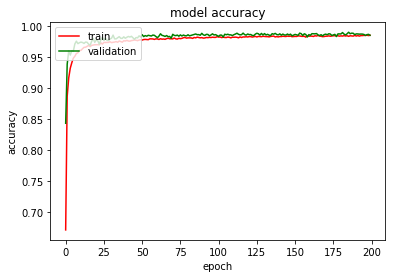

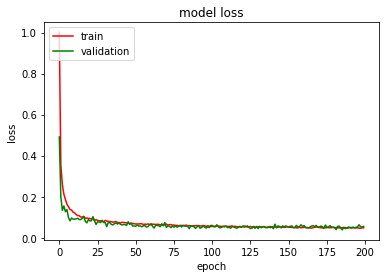

In [23]:
plt.plot(history.history['acc'],color='r')
plt.plot(history.history['val_acc'],color='g')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'],color='r')
plt.plot(history.history['val_loss'],color='g')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [24]:
y_pred_onehotencoded = cnn_model.predict(X_val)
y_pred = np.argmax(y_pred_onehotencoded,axis=1)
y_true = np.argmax(y_val,axis=1)
print(X_val.shape,y_pred.shape,y_true.shape)

(12000, 28, 28, 1) (12000,) (12000,)


In [25]:
confusion_mtx = confusion_matrix(y_true,y_pred)
print (confusion_mtx)

[[1050   89    0    0    0    0    4    1    0    0]
 [   0 1342    0    1    0    0    0    0    0    0]
 [  50  625  425    0    0    0    0   28    0    1]
 [   0  165    3 1020    0    7    0   33    0   16]
 [   2  174    0    0  999    0    7   10    0    6]
 [  17  146    0    1    1  918    8    8    0   12]
 [   7  192    0    0    1    0 1001    0    0    0]
 [   0  180    0    0    1    0    0 1111    0    1]
 [  30  728    0    0   12    0    7   11  382   31]
 [  12   93    0    0   37    0    2   42    0  950]]


In [26]:
results = cnn_model.predict(X_test)
results = np.argmax(results, axis=1)
y_test_ = np.argmax(y_test,axis=1)
res_confusion_mtx = confusion_matrix(y_test_,results)
print(res_confusion_mtx)

[[ 888   85    0    0    0    0    5    2    0    0]
 [   0 1135    0    0    0    0    0    0    0    0]
 [  54  589  371    0    0    0    0   18    0    0]
 [   1   98    1  871    0    3    0   27    0    9]
 [   0  121    0    0  839    0    9    5    0    8]
 [  15  104    0    6    0  745    4    8    0   10]
 [   8  108    0    0    0    0  842    0    0    0]
 [   0  143    0    0    0    0    0  885    0    0]
 [  39  544    0    0   10    0    8   16  325   32]
 [  18   61    0    0   37    0    3   24    0  866]]


In [27]:
print("\nTEST ACCURACY IS {}%".format(cnn_model.evaluate(X_test,y_test)[1]*100))

 9984/10000 [============================>.] - ETA: 0s
TEST ACCURACY IS 77.66999999999999%
